# Variational Autoencoder for STL Objects

WARNING: this notebook was primarily used during the implementation and debug phase of the VAE. Once comp

The goal of this notebook is to produce a Variational Autoencoder (VAE) that can encode and then decode Voxel objects.

This VAE is based off of the implementation demonstrated in [this YouTube video](https://www.youtube.com/watch?v=LtpU1yBStlU) \[[github](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py)\] \[[paper](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/paper/NIPS_paper_2016.pdf)\]. We refer to this VAE as the "Example VAE" in this notebook.

Other sources of inspiration:
* https://github.com/yilei0620/3D_Conditional_Gan/blob/master/ThreeD_AE.py
* https://github.com/Spartey/3D-VAE-GAN-Deep-Learning-Project/blob/master/3D-VAE-WGAN/model.py

Another good example: https://github.com/hiranumn/DLmodels/blob/master/voxel_modeling/3D-Conv-VAE%20implementation%20(ModelNet%20Chair%20example).ipynb

## Notes

* We still use Thingi10k as our data source. Thingi10k's objects are stl files, so we employ methods explored in stl_voxelization.ipynb to convert each stl file to binvox (a voxel format).
* The Example VAE is written in python with theano and lasagne
* Lasagne's Glorot Uniform initializer \[[docs](https://lasagne.readthedocs.io/en/latest/modules/init.html)\] is the same as Xavier Uniform initializer (Tensorflow's API [docs](https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer)).
* The encoder uses conv3d layers and the decoder uses conv3d_transpose layers; TF describes [here] (https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose) that conv3d_transpose is the opposite of conv3d.

## Env Setup

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

# autoreload modules
%load_ext autoreload
%autoreload 2

# set seeds for reproducibility
np.random.seed(12)
tf.set_random_seed(12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Import

In [3]:
# import data
import env
from data.thingi10k import Thingi10k
from data.stl import save_vectors_as_stl, plot_mesh
from data.voxels import plot_voxels
from models import MODEL_DIR


# from train_vaegan import train_vaegan
from data.modelnet10 import ModelNet10
from data import MODELNET10_TOILET_INDEX, MODELNET10_SOFA_INDEX

In [4]:
class VariationalAutoencoder():
    
    def __init__(self, input_dim, latent_dim, learning_rate, keep_prob, verbose=False, 
                 kl_div_loss_weight=5, recon_loss_weight=5e-4, debug=False, ckpt_dir='voxel_vae'
                ,mashup_weight=0.5):
        """
        Args:
            kl_div_loss_weight: float, weight for KL Divergence loss when computing total loss
            recon_loss_weight: float, weight for reconstruction loss when computing total loss

        """
        # network and training params
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.verbose = verbose
        self.debug = debug
        self.kl_div_loss_weight = kl_div_loss_weight
        self.recon_loss_weight = recon_loss_weight
        self.mashup_weight = mashup_weight
        
        self._input_x = tf.placeholder(tf.float32, shape=(None, self.input_dim, self.input_dim, self.input_dim, 1))
        self._keep_prob = tf.placeholder(dtype=tf.float32)
        self._trainable = tf.placeholder(dtype=tf.bool)

        # add ops to this list as a tuple with (<op name>, <op>) to see them executed, returned, and printed
        # to console during execution
        self._debug_ops = list()
        
        # Construct the TensorFlow Graph
        self.encoder, self.enc_mu, self.enc_sig = self._make_encoder(self._input_x, self._keep_prob, self._trainable)
        self.decoder = self._make_decoder(self.encoder, self._trainable)
        self.loss, self.optimizer, self.mean_recon, self.mean_kl = self._make_loss(self._input_x, self.decoder, self.enc_mu, self.enc_sig)

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        
        # Setup Model Saving
        self.ckpt_dir = os.path.join(MODEL_DIR, ckpt_dir)
        self.saver = tf.train.Saver()
        self.recons_pre = list()
        self.recons_post = list()
        self.losses_kl_div = list()
        self.losses_recon = list()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _print_shape(self, tensor, name=None):
        if self.verbose:
            if not name:
                name = tensor.name
            print('{}:'.format(name), tensor.shape)
        return
    
    def _make_encoder(self, input_x, keep_prob, trainable):
        
        with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
            # tf conv3d: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d
            # tf glorot init: https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer
            conv1 = tf.layers.batch_normalization(tf.layers.conv3d(input_x,
                                     filters=8,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv1)
            # the Example VAE specifies the activation functions as part of the layer
            # we specify the activation function as a seperate tensor
            # it is unknown if this is the preferred method in Tensorflow, but we know
            # it works from work in the 3D-VAE-GAN notebook
            # we also take advantage of batch_normalization
            # more info here:
            # https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
            # with the hope that it gives speed without sacrificing quality
            # tf batch norm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
            # tf elu (exponential linear unit): https://www.tensorflow.org/api_docs/python/tf/nn/elu

            conv2 = tf.layers.batch_normalization(tf.layers.conv3d(conv1,
                                     filters=16,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv2)

            conv3 = tf.layers.batch_normalization(tf.layers.conv3d(conv2,
                                     filters=32,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv3)

            conv4 = tf.layers.batch_normalization(tf.layers.conv3d(conv3,
                                     filters=64,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv4)

            # Apply one fully-connected layer after Conv3d layers
            # tf dense layer: https://www.tensorflow.org/api_docs/python/tf/layers/dense
            dense1 = tf.layers.batch_normalization(tf.layers.dense(conv4,
                                 units=343,
                                 activation=tf.nn.elu,
                                 kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(dense1)
            flatten = tf.layers.flatten(tf.nn.dropout(dense1, keep_prob))
        
            enc_mu = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_mu)
            enc_sig = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_sig)
                                                  
            # epsilon is a random draw from the latent space
            epsilon = tf.random_normal(tf.stack([tf.shape(dense1)[0], self.latent_dim]))
            self._print_shape(epsilon, 'epsilon')
            enc_z = enc_mu + tf.multiply(epsilon, tf.exp(enc_sig))
            self._print_shape(enc_z, 'z')
        return enc_z, enc_mu, enc_sig


        # apply dropout to prevent overtraining
        # why do we flatten?
        enc_output = tf.layers.flatten(tf.nn.dropout(network_output, keep_prob), name='enc_output')
        self._print_shape(enc_output)
        # transform the network output into the latent vector
        z_mu = tf.layers.dense(enc_output,
                         units=self.latent_dim,
                         # Example VAE does not use an initializer here
                         #kernel_initializer=tf.initializers.glorot_uniform(),
                         name='enc_mu')
        self._print_shape(z_mu)

        # Example VAE uses a custom layer to extract sigma
        # Here we borrow sigma calc from 3D-VAE-GAN
        z_sig = 0.5 * tf.layers.dense(enc_output, units=self.latent_dim, name='enc_sig')
        self._print_shape(z_sig, 'enc_sig')

        # epsilon is a random draw from the latent space
        epsilon = tf.random_normal(tf.stack([tf.shape(enc_output)[0], self.latent_dim]))
        self._print_shape(epsilon, 'epsilon')
        z = z_mu + tf.multiply(epsilon, tf.exp(z_sig))
        self._print_shape(z, 'z')

        return z, z_mu, z_sig
    
    def _make_decoder(self, input_z, trainable):
        
        # There is some magic in the Example VAE that adds conditional input based on the
        # class of the image. We do not have that luxury as we are attempting to do this
        # with input that lacks classes.
        # TODO: if poor results, try classes
        self._print_shape(input_z, 'input_z')

        # Why conv3d_transpose instead of conv3d?
        #
        # from https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose,
        #     "This operation is sometimes called "deconvolution" after Deconvolutional Networks,
        #      but is actually the transpose (gradient) of conv3d rather than an actual deconvolution."
        #
        # conv3d_transpose: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d_transpose
        dense1 = tf.layers.dense(input_z,
                                 units=343,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='dec_dense1')
        self._print_shape(dense1)
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable))
        self._print_shape(lrelu1)

        #z = tf.reshape(z, (-1, 1, 1, 1, n_latent))
        reshape_z = tf.reshape(lrelu1, shape=(-1, 7, 7, 7, 1), name='reshape_z')
        self._print_shape(reshape_z)
        #print('reshape_z: ', reshape_z.shape)
        #for value in reshape_z.shape:
        #    print(type(value))

        conv1 = tf.layers.conv3d_transpose(reshape_z,
                                           filters=64,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           padding='same',
                                           # Example VAE does not mention bias
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv1')
        self._print_shape(conv1)
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='dec_lrelu2')
        self._print_shape(lrelu2)

        conv2 = tf.layers.conv3d_transpose(lrelu2,
                                           filters=32,
                                           kernel_size=[3, 3, 3],
                                           # Example VAE used .5 stride values, but Tensorflow complains
                                           # of being forced to use a float value here
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='valid',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv2')
        self._print_shape(conv2)
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='dec_lrelu3')
        self._print_shape(lrelu3)

        conv3 = tf.layers.conv3d_transpose(lrelu3,
                                           filters=16,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           # changed to valid to hit correct dimension
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv3')
        self._print_shape(conv3)
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='dec_lrelu4')
        self._print_shape(lrelu4)

        conv4 = tf.layers.conv3d_transpose(lrelu4,
                                           filters=8,
                                           kernel_size=[4, 4, 4],
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='valid',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv4')
        self._print_shape(conv4)
        lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='dec_lrelu5')
        self._print_shape(lrelu5)

        conv5 = tf.layers.conv3d_transpose(lrelu5,
                                           filters=1,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv5')
        self._print_shape(conv5)
        #decoded_output = tf.nn.tanh(conv5)
        decoded_output = tf.nn.sigmoid(conv5)
        #decoded_output = tf.clip_by_value(decoded_output, 1e-7, 1.0 - 1e-7)
        #self._add_debug_op('max decoded_output', tf.math.reduce_max(decoded_output), False)
        #self._add_debug_op('min decoded_output', tf.math.reduce_min(decoded_output), False)
        #self._add_debug_op('mean decoded_output', tf.math.reduce_mean(decoded_output), False)
        #decoded_output = conv5
        self._print_shape(decoded_output)
        
        return decoded_output
    
    def _make_loss(self, enc_input, dec_output, z_mu, z_sig):
        """
        Info on loss in VAE:
          * https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder
          
        Args:
            enc_input: tensor, input tensor into VAE
            dec_output: tensor, decoded output tensor from VAE

        Return:
            float, 
        """
        
        # Weighted binary cross-entropy for use in voxel loss. Allows weighting of false positives relative to false negatives.
        # Nominally set to strongly penalize false negatives
        # we must clip because values of 0 or 1 will cause errors
        #clipped_input = tf.clip_by_value(tf.nn.sigmoid(enc_input), 1e-7, 1.0 - 1e-7)
        clipped_input = tf.clip_by_value(enc_input, 1e-7, 1.0 - 1e-7)
        clipped_output = tf.clip_by_value(dec_output, 1e-7, 1.0 - 1e-7)
        #self._add_debug_op('max clipped_input', tf.math.reduce_max(clipped_input), False)
        #self._add_debug_op('min clipped_input', tf.math.reduce_min(clipped_input), False)
        #self._add_debug_op('mean clipped_input', tf.math.reduce_mean(clipped_input), False)
        self._add_debug_op('max clipped_output', tf.math.reduce_max(clipped_output), False)
        self._add_debug_op('min clipped_output', tf.math.reduce_min(clipped_output), False)
        self._add_debug_op('mean clipped_output', tf.math.reduce_mean(clipped_output), False)
        bce = -(98.0 * clipped_input * tf.log(clipped_output) + 2.0 * (1.0 - clipped_input) * tf.log(1.0 - clipped_output)) / 100.0
        #self._add_debug_op('bce', bce, False)
        #bce = tf.keras.backend.binary_crossentropy(enc_output, dec_output)
        
        # Voxel-Wise Reconstruction Loss 
        # Note that the output values are clipped to prevent the BCE from evaluating log(0).
        recon_loss = tf.reduce_mean(bce, 1)
   
        #recon_loss = tf.reduce_sum(tf.squared_difference(
        #    tf.reshape(dec_output, (-1, self.input_dim ** 3)),
        #    tf.reshape(self._input_x, (-1, self.input_dim ** 3))), 1)
        
        kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_sig - z_mu ** 2 - tf.exp(2.0 * z_sig), 1)

        mean_kl = tf.reduce_sum(kl_divergence)
        #self._add_debug_op('mean_kl', mean_kl, False)
        mean_recon = tf.reduce_sum(recon_loss)
        #self._add_debug_op('mean_recon', mean_recon, False)

        # tf reduce_mean: https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
        loss = tf.reduce_mean(self.kl_div_loss_weight * kl_divergence + self.recon_loss_weight * recon_loss)
        #self._add_debug_op('loss', loss, False)
        # remove kl for fun
        #loss = tf.reduce_mean(self.recon_loss_weight * recon_loss)
        
        #optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)
        optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)

        return loss, optimizer, mean_recon, mean_kl

    def _add_debug_op(self, name, op, newline=True):
        self._debug_ops.append((name, op, newline))
        return

    def _print_debug_ops(self, results):
        if self.debug:
            for i, debug_op in enumerate(self._debug_ops):
                msg = 'DEBUG_OP "{}": '.format(debug_op[0])
                if len(debug_op) > 2 and debug_op[2]:
                    msg += '\n'
                msg += '{}'.format(results[i])
                print(msg)
        return

    def train(self, generator, epochs=10, input_repeats=1, display_step=1, save_step=1, viz_data=None):
        
        start = time.time()
        for epoch_num, epoch in enumerate(range(epochs)):

            for batch_num, batch in enumerate(generator()):
                
                if self.verbose:
                    print('Epoch: {}, Batch: {}, Elapsed time: {:.2f} mins'.format(epoch_num, batch_num, (time.time() - start) / 60))
                #print("batch.min()", batch.min())
                #print("batch.max()", batch.max())
                # repeat for extra practice on each shape
                for _ in range(input_repeats):

                    ops = tuple([self.optimizer, self.loss, self.mean_kl, self.mean_recon] + 
                                [op for name, op, _ in self._debug_ops])
                    results = self.sess.run(
                        ops,
                        feed_dict={self._input_x: batch, self._keep_prob:self.keep_prob, self._trainable: True}
                    )
                    _, loss, kl_divergence, recon_loss = results[:4]
                    self._print_debug_ops(results[4:])
                    
                if self.verbose:
                    #print('\tKL Divergence = {:.5f}, Reconstruction Loss = {:.5f}'.format(kl_divergence, recon_loss))
                    print('\tKL Divergence = {}, Reconstruction Loss = {}'.format(kl_divergence, recon_loss))
                
            if (epoch + 1) % display_step == 0:
                print("Epoch: {}, ".format(epoch + 1) + 
                      "Loss = {:.5f}, ".format(loss) + 
                      "KL Divergence = {:.5f}, ".format(kl_divergence) +
                      "Reconstruction Loss = {:.5f}, ".format(recon_loss) +
                      "Elapsed time: {:.2f} mins".format((time.time() - start) / 60))
                print('Generation Example:')
                
                # prepare for generation
                #print(batch[0][0])
                if viz_data is not None:
                    self._print_shape(viz_data, 'Example shape (before reshape)')
                    recon_input = np.reshape(viz_data, (1, self.input_dim, self.input_dim, self.input_dim, 1))
                    self._print_shape(recon_input, 'Example shape')

                    # generate!
                    recon = self.reconstruct(recon_input)
                    self._print_shape(recon, 'Recon')

                    # prepare for plotting
                    recon_input = np.reshape(recon_input, (self.input_dim, self.input_dim, self.input_dim))
                    self._print_shape(recon_input, 'Example shape (for plotting)')
                    recon = np.reshape(recon, (self.input_dim, self.input_dim, self.input_dim))
                    self._print_shape(recon, 'Recon (for plotting)')
                    # network outputs decimals; here we force them to True/False for plotting
                    self.recons_pre.append(recon)
                    recon = recon > 0.5
                    self.recons_post.append(recon)
                    # replace all nans with zeros
                    #recon = np.nan_to_num(recon)

                    # save the generated object in case we wish to review later
                    path = os.path.join(self.ckpt_dir, 'recon_epoch-{}.npy'.format(epoch))

                    # visualize
                    self.visualize_reconstruction(recon_input, recon)

            if (epoch + 1) % save_step == 0:
                # Save the variables to disk.
                save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))
                print("Model saved in path: {}".format(save_path))
                                       
        return

    def restore(self, model_ckpt):
        self.saver.restore(self.sess, model_ckpt)
        return
    
    def close(self):
        self.sess.close()
        return
            
    def reconstruct(self, input_x):
        """
        Use VAE to reconstruct given data
        """
        ops = tuple([self.decoder] + [op for name, op, _ in self._debug_ops])
                    
        results = self.sess.run(ops, 
            feed_dict={self._input_x: input_x, self._keep_prob: 1.0, self._trainable: False})
        
        decoded = results[0]
        self._print_debug_ops(results[1:])
                    
        return decoded
    
    ### test the mashup ###########
    
    def interp(v1, v2, steps):
        vecs = []
        step = (v2-v1)/steps
        for i in range(steps):
            vecs.append(v1+step*i)
        vecs.append(v2)

        return vecs
    
    def mashup(self, input_x1, input_x2):
        """
        Use VAE to reconstruct given data
        """
        ops = tuple([self.encoder] + [self.decoder] + [op for name, op, _ in self._debug_ops])

        # first 3d object
        result_1 = self.sess.run(ops, 
            feed_dict={self._input_x: input_x1, self._keep_prob: 1.0, self._trainable: False})
        # second 3d object
        result_2 = self.sess.run(ops, 
            feed_dict={self._input_x: input_x2, self._keep_prob: 1.0, self._trainable: False})

        # extract vector space for each
        encoder_1 = result_1[0]
        encoder_2 = result_2[0]
        # add two vector space into one, use interpolation?
#         new_vector = self.mashup_weight*encoder_1 + (1-self.mashup_weight)*encoder_2
        new_vector = interp(encoder_1, encoder_2, 9)[1] # generate 9 arrays, use the 1 interpolated; should use variable
                                                        # so that we could plot all of them, from similar to object 1 to object 2
        # construct the object using derived vector space above
        results = self.sess.run(self.decoder, 
            feed_dict={self.encoder: new_vector, self._trainable: False})
        decoded = results[0]

        return decoded
    ##################################################################
    
    def visualize_reconstruction(self, original_x, reconstructed_x, name=None):
        title = '' if not name else ': {}'.format(name)
        plot_voxels(original_x, title='Original' + title)
        plot_voxels(reconstructed_x, title='Autoencoded' + title)
        return

    def __repr__(self):
        return '<VariationalAutoencoder(input_dim={}, latent_dim={}, learning_rate={}, keep_prob={})>'.format(
            self.input_dim, self.latent_dim, self.learning_rate, self.keep_prob)


## Training

The model is having issues producing an output that is recognizable.

Experiments:
* Large & small datasets produce the same result
* latent_dim variations have no effect
* Too high of a learning rate causes the loss to go down then up and sometimes fluctuate
* Removing dropout (keep_prob=1.0) with lr=0.00001 on a single training example causes loss to go down as expected but output is still not recognizable
* Upping recon_loss_weight seems to cause more variation in decoded output
* Severe upping of recon_loss_weight (recon=5, kl=5e-4) delivered loss of ~5 after 500 epochs on a single training example with 20 input_repeats
* 500 epochs with above settings and RMSPropOptimizer achieved loss of <1 after about 200 epochs; viz still unimpressive
* Increasing recon_loss_weight to 5e5 and dumping recon loss and kl divergence values reveals that recon loss is diminishing. Question: what is the input to recon loss? an array of 1s and 0s or TRUEs and FALSEs? A: 1s and 0s
* Using weight binary cross entropy for recon loss as according to Example VAE shows same loss reduction pattern with still unimpressive recon
* Equalized loss weights yielded no change (at 100 epochs on one square example with 50 input_repeats, viz was all 1s)
* By dumping out counts of True vs False of each recon, I can see that False goes down while True goes up to the point where they are almost all Trues after 50 epochs
* Run through all training examples produces loss of nan
* Added homebaked debug_ops and discovered that the dec_output is nan and not the loss functions!
* latent_dim=100, lr=0.0001, dataset=animals, keep_prob=1.0, kl_loss_weight=1, recon_loss_weight=1e4, batch_size=22, epochs=50 -- kind of reconstructed 126660 the bird! Used a threshold of 0.085 though.

Notes:

* The model is assigning a high probability to the outside layer of the cube. As you decrease the threshold, that outside layer begins to build. Why? How many training examples even have voxels in those locations? 
* You would expect the center voxel to always have the highest probability as all input is centered and thus would fill that voxel.

Todo:
* Move model into .py file
* Move training config into .py file that can be edited/saved
* Improve model saving/restoring/labeling
* *Combine VAE with GAN for VAE-GAN!*

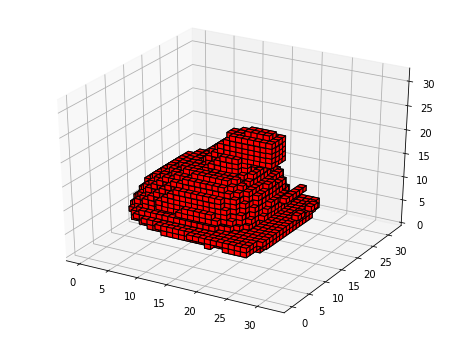

In [5]:
VOXELS_DIM = 32
BATCH_SIZE = 64

DATASET_CLASS = 'ModelNet10'
INDEX = MODELNET10_TOILET_INDEX

modelnet = ModelNet10.initFromIndex(INDEX)
training_example = modelnet.get_random_voxels(32)

plot_voxels(training_example)
training_example = np.reshape(training_example, (-1, 32, 32, 32, 1))

In [11]:
tf.reset_default_graph()

try:
    vae = VariationalAutoencoder(input_dim=VOXELS_DIM,
                                 latent_dim=50,
                                 learning_rate=0.001,
                                 keep_prob=1.0,
                                 kl_div_loss_weight=1,
                                 recon_loss_weight=1e4,
                                 verbose=True,
                                 debug=True)

#     generator = lambda: thingi.voxels_batchmaker(batch_size=BATCH_SIZE, voxels_dim=VOXELS_DIM, verbose=False)
    generator = lambda: modelnet.voxels_batchmaker(batch_size=BATCH_SIZE, voxels_dim=VOXELS_DIM)
    vae.train(generator, epochs=2, input_repeats=1, display_step=10, save_step=100)
except Exception as exc:
    vae.close()
    raise(exc)

encoder/batch_normalization/batchnorm/add_1:0: (?, 30, 30, 30, 8)
encoder/batch_normalization_1/batchnorm/add_1:0: (?, 15, 15, 15, 16)
encoder/batch_normalization_2/batchnorm/add_1:0: (?, 13, 13, 13, 32)
encoder/batch_normalization_3/batchnorm/add_1:0: (?, 7, 7, 7, 64)
encoder/batch_normalization_4/batchnorm/add_1:0: (?, 7, 7, 7, 343)
encoder/batch_normalization_5/batchnorm/add_1:0: (?, 50)
encoder/batch_normalization_6/batchnorm/add_1:0: (?, 50)
epsilon: (?, 50)
z: (?, 50)
input_z: (?, 50)
dec_dense1/BiasAdd:0: (?, 343)
Elu:0: (?, 343)
reshape_z:0: (?, 7, 7, 7, 1)
dec_conv1/conv3d_transpose:0: (?, 7, 7, 7, 64)
dec_lrelu2:0: (?, 7, 7, 7, 64)
dec_conv2/conv3d_transpose:0: (?, 15, 15, 15, 32)
dec_lrelu3:0: (?, 15, 15, 15, 32)
dec_conv3/conv3d_transpose:0: (?, 15, 15, 15, 16)
dec_lrelu4:0: (?, 15, 15, 15, 16)
dec_conv4/conv3d_transpose:0: (?, 32, 32, 32, 8)
dec_lrelu5:0: (?, 32, 32, 32, 8)
dec_conv5/conv3d_transpose:0: (?, 32, 32, 32, 1)
Sigmoid:0: (?, 32, 32, 32, 1)


C:\Users\cynth\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0, Batch: 0, Elapsed time: 0.00 mins
DEBUG_OP "max clipped_output": 0.9993496537208557
DEBUG_OP "min clipped_output": 0.00333590479567647
DEBUG_OP "mean clipped_output": 0.5429911017417908
	KL Divergence = 12.686199188232422, Reconstruction Loss = 10590.7900390625
Epoch: 0, Batch: 1, Elapsed time: 0.08 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 9.038322446031088e-07
DEBUG_OP "mean clipped_output": 0.7781150341033936
	KL Divergence = 25.72205352783203, Reconstruction Loss = 11959.35546875
Epoch: 0, Batch: 2, Elapsed time: 0.19 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 0.9999998807907104
DEBUG_OP "mean clipped_output": 0.9999999403953552
	KL Divergence = 400.843017578125, Reconstruction Loss = 14758.1767578125
Epoch: 0, Batch: 3, Elapsed time: 0.36 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 0.9999998807907104
DEBUG_OP "mean clipped_output": 0.9999999403

DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 0, Batch: 41, Elapsed time: 4.03 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 0, Batch: 42, Elapsed time: 4.13 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 0, Batch: 43, Elapsed time: 4.22 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 0, Batch: 44, Elapsed time: 4.32 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 0, Batch: 45, Elapsed time: 4.41 mins


DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 0, Batch: 82, Elapsed time: 7.97 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 0, Batch: 83, Elapsed time: 8.07 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 0, Batch: 84, Elapsed time: 8.16 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 0, Batch: 85, Elapsed time: 8.26 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 0, Batch: 86, Elapsed time: 8.35 mins


DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 12, Elapsed time: 11.90 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 13, Elapsed time: 11.99 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 14, Elapsed time: 12.08 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 15, Elapsed time: 12.18 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 16, Elapsed time: 12.28 

DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 53, Elapsed time: 15.81 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 54, Elapsed time: 15.91 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 55, Elapsed time: 16.00 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 56, Elapsed time: 16.09 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 57, Elapsed time: 16.19 

DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 94, Elapsed time: 19.71 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 95, Elapsed time: 19.80 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 96, Elapsed time: 19.90 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 97, Elapsed time: 20.00 mins
DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan
	KL Divergence = nan, Reconstruction Loss = nan
Epoch: 1, Batch: 98, Elapsed time: 20.09 

DEBUG_OP "max clipped_output": -inf
DEBUG_OP "min clipped_output": inf
DEBUG_OP "mean clipped_output": nan


<module 'matplotlib.pyplot' from 'C:\\Users\\cynth\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

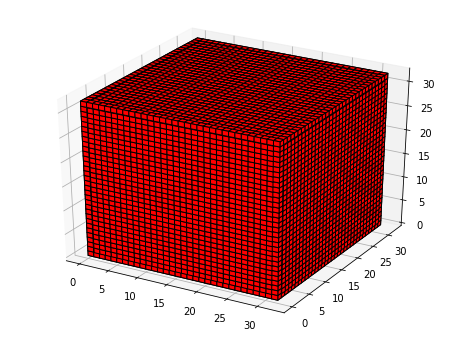

In [13]:
# reconstruct
recon = vae.reconstruct(training_example)
recon = np.reshape(recon, [VOXELS_DIM, VOXELS_DIM, VOXELS_DIM])
# recon = recon > 0.01
plot_voxels(recon)

NameError: name 'interp' is not defined

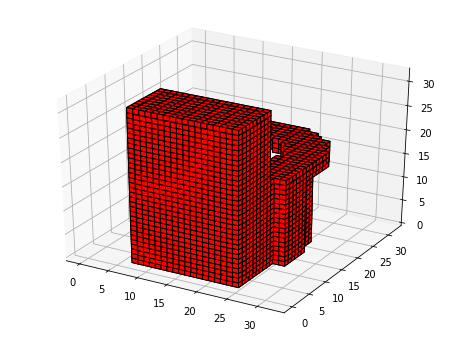

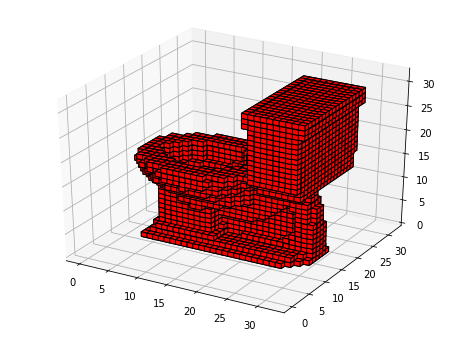

In [14]:
####### mashup two objects ###############3
vox_data_1 = modelnet.get_random_voxels(32)
plot_voxels(vox_data_1)
vox_data_1 = np.reshape(vox_data_1, (-1, 32, 32, 32, 1))

vox_data_2 = modelnet.get_random_voxels(32)
plot_voxels(vox_data_2)
vox_data_2 = np.reshape(vox_data_2, (-1, 32, 32, 32, 1))

mashup = vae.mashup(vox_data_1, vox_data_2)
mashup = np.reshape(mashup, [VOXELS_DIM, VOXELS_DIM, VOXELS_DIM])
# mashup = mashup > 0.028
plot_voxels(mashup)

In [79]:
# save the stl file
from skimage import measure
output_dir = os.path.join('_output', '3d-vae-gan')
os.makedirs(output_dir, exist_ok=True)
graphs_dir = os.path.join(output_dir, 'graphs')
os.makedirs(graphs_dir, exist_ok=True)

verts, faces, normals, values = measure.marching_cubes_lewiner(mashup, 0)
save_vectors_as_stl(verts[faces], os.path.join(graphs_dir, 'vae_toilet.stl'))